In [59]:
import scipy.optimize as optimize
import numpy as np

def f(q):
    r = 83.74 * q - 0.21 * q ** 2
    return -r

x = optimize.fmin(f, 0)

print(x)

Optimization terminated successfully.
         Current function value: -8348.080476
         Iterations: 40
         Function evaluations: 80
[199.3809375]


In [60]:
pd.DataFrame({'q': np.arange(180, 221, 1)}) \
    .assign(r=lambda d: -f(d.q), p=lambda d: d.r / d.q) \
    .sort_values(['r'], ascending=False) \
    .head(10)

,q,r,p
19,199,8348.05,41.95
20,200,8348.00,41.74
18,198,8347.68,42.16
21,201,8347.53,41.53
17,197,8346.89,42.37
22,202,8346.64,41.32
16,196,8345.68,42.58
23,203,8345.33,41.11
15,195,8344.05,42.79
24,204,8343.60,40.90


<Axes: xlabel='p'>

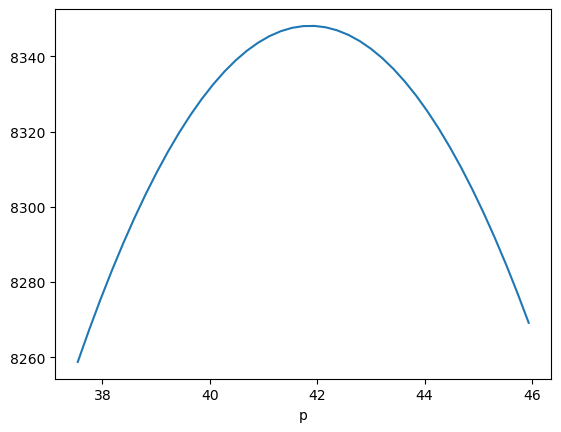

In [61]:
import pandas as pd

pd.DataFrame({'q': np.arange(180, 221, 1)}) \
    .assign(r=lambda d: -f(d.q), p=lambda d: d.r / d.q) \
    .set_index(['p'])['r'] \
    .plot(kind='line')

In [68]:
def f(tup):
    x, y = tup
    z = np.sin(np.sqrt(x ** 2 + y ** 2))
    return -z

x = optimize.fmin(f, np.array([0, 0]), ftol=1e-30, xtol=1e-30, maxiter=10_000, maxfun=10_000)

print(x)

Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 97
         Function evaluations: 266
[1.54456722 0.28585516]


In [73]:
-f(x), -f(np.array([1.54456722, 0.28585516])), -f(np.array([0, 1.5]))

(1.0, 1.0, 0.9974949866040544)